# Importowanie niezbędnych bibliotek

In [1]:
# Importy standardowej biblioteki
import glob
import os
from datetime import datetime

# Importy bibliotek zewnętrznych
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report)

# Importy własnych modułów
from config import BATCH_SIZE, DEVICE,TEST_SPLIT, CLASS_NAMES,FEATURE_RESULTS_DIR, PROCESSED_FEATURES_DIR, ENSEMBLE_OUTPUT_DIR, OPTUNA_TRIALS, OPTUNA_TIMEOUT, CV_FOLDS, SEED

from helpers.resnet_model_definition import AudioResNet

from helpers.ensemble_trainer import EnsembleModelTrainer

# Ustawienie domyślnego urządzenia
print(f"Using device: {DEVICE}")

Using device: cpu


## Automatyczna konfiguracja modelu ensemble

### Funkcja `find_latest_model`
**Opis:**  
Ta funkcja wyszukuje najnowszy plik modelu dla określonego typu cechy audio w katalogu z wynikami. Wykorzystuje wzorzec nazwy pliku, aby znaleźć wszystkie modele dla danego typu cechy, a następnie sortuje je według daty w nazwie pliku, zwracając najnowszy.

**Uzasadnienie:**  
Wybór najnowszego modelu jest kluczowy w procesie ensemble, ponieważ zapewnia, że używane są najbardziej aktualne wyniki treningu, co może wpływać na lepszą dokładność predykcji.

### Funkcja `find_feature_file`
**Opis:**  
Funkcja ta wyszukuje plik z cechami audio dla określonego typu reprezentacji w katalogu z przetworzonymi cechami. Jeśli znajdzie więcej niż jeden plik, wybiera najnowszy na podstawie daty modyfikacji.

**Uzasadnienie:**  
Wybór odpowiedniego pliku z cechami jest niezbędny do zapewnienia, że dane wejściowe do modelu są aktualne i zgodne z typem cechy, co pozwala na spójność między danymi a modelem podczas predykcji lub treningu.

### Funkcja `auto_configure_ensemble`
**Opis:**  
Funkcja automatycznie konfiguruje model ensemble, wyszukując dostępne typy cech w katalogu wyników, znajdując odpowiednie modele i pliki cech dla każdego typu, a następnie tworząc konfigurację z modelami, plikami cech, wagami początkowymi i parametrami eksperymentu.
W tym fragmencie kodu definiowana jest struktura config jako słownik, który zawiera kluczowe ustawienia modelu ensemble. Obejmuje ścieżki do modeli (model_paths) i plików cech (feature_files), klasę modelu (AudioResNet z pliku resnet_model_definition.py), początkowe wagi dla ensemble (initial_weights), katalog wyjściowy (output_dir z config.py), nazwę eksperymentu, podział danych na testowe (test_split), rozmiar partii (batch_size), parametry optymalizacji Optuna (optimization), nazwy klas emocji (class_names) oraz ziarno losowości (random_seed), z których większość pochodzi z pliku config.py.

**Uzasadnienie:**  
Automatyczna konfiguracja pozwala na szybkie zestawienie modelu ensemble bez konieczności ręcznego określania ścieżek do modeli i plików cech, co minimalizuje ryzyko błędów ludzkich i przyspiesza proces przygotowania do treningu lub testowania. Funkcja sprawdza również, czy wszystkie wymagane pliki istnieją, co zapobiega problemom podczas dalszej pracy. Konfiguracja config centralizuje wszystkie parametry potrzebne do treningu i testowania modelu ensemble, zapewniając spójność między ustawieniami projektu (config.py), architekturą modelu (resnet_model_definition.py) a danymi, co ułatwia automatyzację i powtarzalność eksperymentów.


In [2]:
def find_latest_model(feature_type):
    """Zwraca najnowszy model dla danej reprezentacji audio."""
    search_pattern = f"{FEATURE_RESULTS_DIR}/{feature_type}/best_model_{feature_type}_*.pt"
    model_files = glob.glob(search_pattern)
    
    if not model_files:
        return None
    
    # Sortowanie plików według daty w nazwie (najnowszy na końcu)
    model_files.sort(key=lambda x: os.path.basename(x).split('_')[-1].split('.')[0])
    return model_files[-1]

def find_feature_file(feature_type):
    """Zwraca plik z cechami dla danej reprezentacji audio."""
    search_pattern = f"{PROCESSED_FEATURES_DIR}/{feature_type}_*.pkl"
    feature_files = glob.glob(search_pattern)
    
    if not feature_files:
        return None
    
    # W przypadku wielu plików, wybór najnowszego
    if len(feature_files) > 1:
        feature_files.sort(key=os.path.getmtime, reverse=True)
    
    return feature_files[0]

def auto_configure_ensemble(feature_types=None):
    """
    Konfiguracja modelu ensemble w sposób automatyczny.
    """
    # Wykorzystanie zmiennych z config.py
    if feature_types is None:
        try:
            feature_types = [d for d in os.listdir(FEATURE_RESULTS_DIR) 
                             if os.path.isdir(os.path.join(FEATURE_RESULTS_DIR, d))]
        except FileNotFoundError:
             raise FileNotFoundError(f"Nie znaleziono katalogu '{FEATURE_RESULTS_DIR}'.")
    
    print(f"Typy cech wybrane do modelu ensemble: {', '.join(feature_types)}")

    model_paths = {}
    feature_files = {}
    initial_weights = {}
    missing_feature_files = []
    
    for feature_type in feature_types:
        # Weryfikacja pliku cech
        feature_file = find_feature_file(feature_type)
        if not feature_file:
            missing_feature_files.append(feature_type)
            print(f"Ostrzeżenie: Brak pliku cech dla {feature_type}")
            continue # Kontynuacja do następnego typu, bez szukania modelu, gdy brak cech
        
        feature_files[feature_type] = feature_file
        
        # Wyszukiwanie modelu
        model_path = find_latest_model(feature_type)
        if model_path:
            model_paths[feature_type] = model_path
            initial_weights[feature_type] = 1.0 # Waga do normalizacji w późniejszym etapie
        else:
            print(f"Ostrzeżenie: Brak modelu dla {feature_type}, mimo istnienia pliku cech.")
            # Decyzja o kontynuacji bez tego modelu lub zgłoszenie błędu.
            # Na razie pominięcie tego typu cechy w modelu.
            del feature_files[feature_type] # Usunięcie wpisu o pliku cech, gdy brak modelu
            
    # W przypadku brakujących plików cech, zgłoszenie błędu
    if missing_feature_files:
        error_message = (
            f"Błąd: Brak plików cech dla: {', '.join(missing_feature_files)}. "
            f"Zaleca się uruchomienie funkcji `process_dataset` w pliku `ResNet_porównanie.ipynb`, "
            f"aby wygenerować brakujące pliki w folderze `processed_features`."
        )
        raise FileNotFoundError(error_message)
        
    # Weryfikacja, czy znaleziono jakiekolwiek działające pary model-cechy
    if not model_paths:
        raise ValueError("Brak działających modeli i odpowiadających im plików cech! "
                         "Zaleca się sprawdzenie folderów 'feature_comparison_results' i 'processed_features'.")

    # Normalizacja wag, aby sumowały się do 1
    num_features = len(model_paths)
    initial_weights = {k: 1.0 / num_features for k in model_paths.keys()}
    
    # Tworzenie konfiguracji
    config = {
        "model_paths": model_paths,
        "model_class": AudioResNet,
        "feature_files": feature_files,
        "initial_weights": initial_weights,
        "output_dir": ENSEMBLE_OUTPUT_DIR,
        "experiment_name": f"ensemble_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        "test_split": TEST_SPLIT,
        "batch_size": BATCH_SIZE,
        "optimization": {
            "n_trials": OPTUNA_TRIALS,
            "timeout": OPTUNA_TIMEOUT,
            "n_folds": CV_FOLDS
        },
        "class_names": CLASS_NAMES,
        "random_seed": SEED
    }
    
    
    print(f"\nZnaleziono {len(model_paths)} działających par model-cechy:")
    for feat in model_paths.keys():
        print(f"  - {feat}")
    
    return config

## Konfiguracja modelu ensemble z wybranymi cechami

In [3]:
# Automatyczne wykrywanie dostępnych modeli
# CONFIG = auto_configure_ensemble()

# Selekcja konkretnych reprezentacji
selected_features = ["melspectrogram", "mfcc", "chroma"]
CONFIG = auto_configure_ensemble(feature_types=selected_features)

# Modyfikacja wygenerowanej konfiguracji w celu dostosowania liczby prób optymalizacji
# CONFIG["optimization"]["n_trials"] = 100  # Ustalenie liczby prób optymalizacji

Wybrane typy cech do modelu ensemble: melspectrogram, mfcc, chroma

Znaleziono 3 działających par model-cechy:
  - melspectrogram
  - mfcc
  - chroma


## Opis funkcji `auto_configure_ensemble`:
Funkcja `auto_configure_ensemble` w pliku `ResNet_ensemble.ipynb` automatycznie przygotowuje model ensemble, przeszukując katalogi zdefiniowane w `config.py` w poszukiwaniu najnowszych modeli i plików cech dla różnych reprezentacji audio. Tworzy konfigurację zawierającą ścieżki do modeli, pliki cech, klasę modelu `AudioResNet` (z resnet_model_definition.py), znormalizowane wagi początkowe oraz parametry eksperymentu i optymalizacji.
## Uzasadnienie architektury i featurów:
Architektura ensemble łączy predykcje różnych modeli bazowych, analizujących odmienne cechy audio, co pozwala lepiej uchwycić emocje w dźwięku. W szczególności model ensemble osiągnął najlepsze wyniki po kilku próbach z różnymi konfiguracjami, wykorzystując trzy reprezentacje: chroma (harmonia i tony), melspectrogram (częstotliwości dostosowane do ludzkiego słuchu) oraz mfcc (cechy cepstralne istotne w analizie mowy). Automatyzacja konfiguracji oszczędza czas i minimalizuje błędy, umożliwiając skupienie się na analizie wyników.
## Analiza pliku `ensemble_trainer.py`:
Plik `ensemble_trainer.py` definiuje klasę `EnsembleModelTrainer`, która zarządza trenowaniem i oceną modelu ensemble. Odpowiada za ładowanie modeli   `AudioResNet` i danych cech, optymalizację wag za pomocą Optuna (z parametrami z `config.py`), ocenę modelu na zbiorze testowym, generowanie macierzy pomyłek oraz analizę błędów. Wykorzystuje MLflow do logowania eksperymentów, a walidacja krzyżowa i podział danych (zgodnie z `TEST_SPLIT`) zapewniają rzetelność wyników.

Zastosowanie ensemble z wybranymi cechami audio (chroma, melspectrogram, mfcc) pozwala uchwycić złożoność emocji w dźwiękach, a modularna struktura `EnsembleModelTrainer` ułatwia zarządzanie eksperymentami. Automatyzacja optymalizacji wag i logowanie wyników wspierają efektywność i powtarzalność, co jest kluczowe w badaniach nad rozpoznawaniem emocji.

In [4]:
# Inicjalizacja konfiguracji
if 'CONFIG' not in locals():
    try:
        print("Rozpoczynanie automatycznego generowania konfiguracji...")
        CONFIG = auto_configure_ensemble() 
    except Exception as e:
        raise NameError(f"Zmienna CONFIG nie jest zdefiniowana i nie udało się jej automatycznie wygenerować: {e}. Należy najpierw uruchomić komórkę konfiguracyjną lub upewnić się, że pliki modeli/cech są dostępne.")

# Tworzenie głównego katalogu wyjściowego dla bieżącego uruchomienia
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Wykorzystanie podstawowego output_dir z konfiguracji
base_output_dir = CONFIG.get("output_dir", "ensemble_outputs") 
output_dir = os.path.join(base_output_dir, f"ensemble_run_{timestamp}")
os.makedirs(output_dir, exist_ok=True)
print(f"Główny katalog wyjściowy utworzony: {output_dir}")

# Tworzenie podkatalogów w obrębie specyficznego dla uruchomienia output_dir
os.makedirs(os.path.join(output_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "evaluation"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "optimization_plots"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "error_analysis"), exist_ok=True) 
os.makedirs(os.path.join(output_dir, "calibration"), exist_ok=True)  
os.makedirs(os.path.join(output_dir, "logs"), exist_ok=True)       

# Zapewnienie istnienia katalogu mlruns oraz jego struktury
mlruns_dir = "./mlruns"
os.makedirs(mlruns_dir, exist_ok=True)
os.makedirs(os.path.join(mlruns_dir, ".trash"), exist_ok=True)

# Inicjalizacja MLflow
mlflow_initialized = False # Zakłada się, że inicjalizacja nie powiodła się
try:
    mlflow.set_tracking_uri(f"file:{mlruns_dir}")
    # Wykorzystanie nazwy eksperymentu z konfiguracji
    experiment_name = CONFIG.get("experiment_name", f"ensemble_model_{timestamp}") 
    mlflow.set_experiment(experiment_name)
    mlflow_initialized = True
    print(f"Inicjalizacja MLflow zakończona: {mlflow_initialized}")
    print(f"Nazwa eksperymentu MLflow: {experiment_name}")
except Exception as e:
    print(f"Ostrzeżenie: Inicjalizacja MLflow nie powiodła się: {e}")
    print("Kontynuowanie bez śledzenia MLflow.")

# Inicjalizacja trenera z odpowiednim output_dir
trainer = EnsembleModelTrainer(
    model_paths=CONFIG["model_paths"],
    feature_files=CONFIG["feature_files"],
    model_class=CONFIG["model_class"],  # Nowy parametr
    output_dir=output_dir
)

print("Inicjalizacja zakończona. Można przystąpić do optymalizacji lub treningu.")

2025/04/25 18:29:50 INFO mlflow.tracking.fluent: Experiment with name 'ensemble_model_20250425_182948' does not exist. Creating a new experiment.


Utworzono główny katalog wyjściowy: c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\ensemble_outputs\ensemble_run_20250425_182950
MLflow initialized: True
MLflow experiment name: ensemble_model_20250425_182948
Initialization complete. Now you can run optimization or training.


## Optymalizacja wag

Poniżej pobierane są parametry optymalizacji z wcześniej zdefiniowanej konfiguracji `CONFIG`, takie jak liczba prób (`n_trials`), limit czasu (`timeout`), liczba foldów walidacji krzyżowej (`n_folds`) oraz proporcja danych testowych (`test_size`). Następnie wywoływana jest metoda `optimize_weights` obiektu `trainer`, która wykorzystuje bibliotekę **Optuna** do znalezienia najlepszych wag dla każdego modelu bazowego w ensemble. Na koniec wyświetlane są informacje o zakończeniu optymalizacji oraz uzyskane najlepsze wagi (`best_weights`).

Optymalizacja wag jest kluczowym krokiem w budowie modelu ensemble, ponieważ pozwala określić, jak bardzo każdy model bazowy (dla różnych cech audio) wpływa na ostateczną predykcję. Użycie Optuna automatyzuje ten proces, testując różne kombinacje wag w oparciu o walidację krzyżową, co prowadzi do poprawy dokładności modelu. Logowanie parametrów i wyników zapewnia przejrzystość i możliwość analizy procesu optymalizacji.

In [5]:
# Komórka odpowiedzialna za optymalizację wag modelu, w której definiowane są parametry optymalizacji
n_trials = CONFIG["optimization"]["n_trials"]
timeout = CONFIG["optimization"]["timeout"]
n_folds = CONFIG["optimization"]["n_folds"]
test_size = CONFIG["test_split"]

print(f"Rozpoczynanie optymalizacji z {n_trials} próbami...")
best_weights = trainer.optimize_weights(
    n_trials=n_trials,
    timeout=timeout,
    n_folds=n_folds,
    test_size=test_size
)

print("Optymalizacja zakończona!")
print(f"Najlepsze wagi: {best_weights}")

Rozpoczynanie optymalizacji z 50 próbami...


2025/04/25 18:30:04 INFO mlflow.tracking.fluent: Experiment with name 'ensemble_optimization_20250425_183004' does not exist. Creating a new experiment.
[I 2025-04-25 18:30:04,453] A new study created in memory with name: ensemble_optimization_20250425_183004
[I 2025-04-25 18:30:26,826] Trial 0 finished with value: 0.9860529986052998 and parameters: {'weight_melspectrogram': 0.3745401188473625, 'weight_mfcc': 0.9507143064099162, 'weight_chroma': 0.7319939418114051}. Best is trial 0 with value: 0.9860529986052998.
[I 2025-04-25 18:30:47,593] Trial 1 finished with value: 0.9888423988842399 and parameters: {'weight_melspectrogram': 0.5986584841970366, 'weight_mfcc': 0.15601864044243652, 'weight_chroma': 0.15599452033620265}. Best is trial 1 with value: 0.9888423988842399.
[I 2025-04-25 18:31:07,879] Trial 2 finished with value: 0.9865178986517898 and parameters: {'weight_melspectrogram': 0.05808361216819946, 'weight_mfcc': 0.8661761457749352, 'weight_chroma': 0.6011150117432088}. Best is 

Optymalizacja zakończona!
Najlepsze wagi: {'melspectrogram': 0.5021211544729384, 'mfcc': 0.4415508715628608, 'chroma': 0.056327973964200626}


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## Trening i ewaluacja modelu

Komórka poniżej umożliwia elastyczne testowanie modelu ensemble z różnymi zestawami wag – zarówno zoptymalizowanymi automatycznie, jak i ustawionymi ręcznie, co pozwala eksperymentować z wpływem poszczególnych reprezentacji audio na wynik. Wywołanie metody `train_and_evaluate` integruje proces treningu i oceny, korzystając z wcześniej przygotowanej konfiguracji.

In [6]:
# Komórka odpowiedzialna za trening i ewaluację modelu, która powinna być uruchomiona po zakończeniu optymalizacji lub przy użyciu zdefiniowanych wag.
# Możliwość wykorzystania wag uzyskanych w poprzednim kroku lub zdefiniowanie własnych wag.
# Przykład z własnymi wagami:
# custom_weights = {
#     "melspectrogram": 0.7,
#     "mfcc": 0.1,
#     "chroma": 0.2
# }

# Wybór wag do użycia, które mogą być najlepszymi wagami lub zdefiniowanymi przez użytkownika
weights_to_use = best_weights  # lub custom_weights, jeśli zdefiniowano

print(f"Trenowanie i ewaluacja modelu z wagami: {weights_to_use}")
ensemble_model, test_results = trainer.train_and_evaluate(
    weights=weights_to_use,
    test_size=CONFIG["test_split"],
    batch_size=CONFIG["batch_size"]
)

print("Trenowanie i ewaluacja zakończona!")
print(f"Dokładność testowa: {test_results['accuracy']:.4f}")
print(f"Wynik F1 testu: {test_results['f1']:.4f}")

Trenowanie i ewaluacja modelu z wagami: {'melspectrogram': 0.5021211544729384, 'mfcc': 0.4415508715628608, 'chroma': 0.056327973964200626}
Trenowanie i ewaluacja zakończona!
Dokładność testowa: 0.9576
Wynik F1 testu: 0.9575


## Szczegółowe wyniki modelu

Raport klasyfikacji:
              precision    recall  f1-score   support

       anger       0.96      0.98      0.97       150
        fear       0.99      0.98      0.98       147
   happiness       0.95      0.92      0.93       150
     neutral       0.95      0.98      0.96       162
     sadness       0.99      0.98      0.98       154
   surprised       0.92      0.90      0.91       134

    accuracy                           0.96       897
   macro avg       0.96      0.96      0.96       897
weighted avg       0.96      0.96      0.96       897



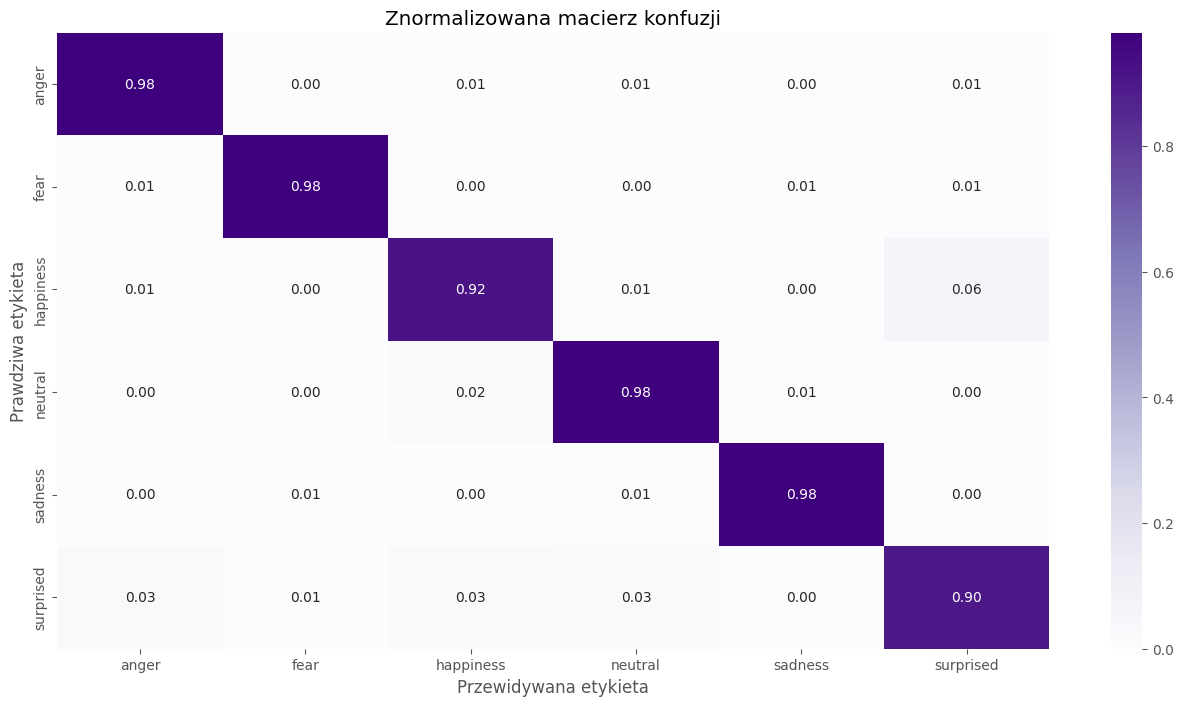

In [7]:
# Komórka odpowiedzialna za wyświetlanie szczegółowych wyników
# Wymagana po zakończeniu procesu treningu i ewaluacji
if 'test_results' in locals():
    # Generowanie szczegółowego raportu klasyfikacji
    print("Raport klasyfikacji:")
    class_names = CONFIG["class_names"]
    print(classification_report(test_results['true'], test_results['preds'], target_names=class_names))
    
    # Tworzenie i wyświetlanie znormalizowanej macierzy konfuzji
    plt.figure(figsize=(16, 8))
    cm_normalized = test_results['cm'].astype('float') / test_results['cm'].sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Purples',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Znormalizowana macierz konfuzji')
    plt.ylabel('Prawdziwa etykieta')
    plt.xlabel('Przewidywana etykieta')
    plt.show()